# Library Imports

In [2]:
%load_ext autoreload
%autoreload 2

%config Completer.use_jedi = False
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import xgboost as xgb
from sklearn.model_selection import train_test_split
import empyrical
from pypfopt.efficient_frontier import EfficientFrontier
import time
import multiprocessing as mp
#import test
from sklearn import linear_model



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Import

In [3]:
tickers = ["GE", "PFE","SBUX", "GME", "DAL", "AAPL", "GOOGL" ]
stocks = pd.concat([yf.Ticker(i).history(period = "max")["Close"].pct_change().dropna().rename(i) for i in tickers], axis=1, join = 'inner')
stocks

,GE,PFE,SBUX,GME,DAL,AAPL,GOOGL
Date,,,,,,,
2007-05-04,-0.005088,0.007816,-0.029095,-0.010122,0.012548,0.004084,-0.004459
2007-05-07,0.002423,0.011078,-0.011401,0.001805,-0.029552,0.030850,-0.008172
2007-05-08,-0.004297,-0.001096,-0.005601,0.004503,-0.035854,0.010970,-0.000984
2007-05-09,0.004854,0.003696,-0.004639,0.001195,0.008151,0.017324,0.005227
2007-05-10,-0.012883,-0.013255,-0.016644,-0.017313,-0.004548,0.004304,-0.016580
...,...,...,...,...,...,...,...
2021-04-14,0.017857,0.000269,-0.001734,0.181148,-0.001865,-0.017853,-0.005554
2021-04-15,-0.009503,0.011568,0.013025,-0.060590,-0.028026,0.018708,0.019332
2021-04-16,-0.011808,0.025798,0.014401,-0.011186,-0.003845,-0.002528,-0.001094


# Manual Get_Weights Function

In [4]:
def get_weights(r0, mean, std, covar):
   
    #mean = [i.mean() for i in stocks]
    #std = [i.std() for i in stocks]
    
    n = len(mean)
    mean = mean.values.reshape((n,1))
    #np.matmul(covar_inverse, covar)

    ones_column = np.ones((n, 1))
    mu_matrix = np.hstack((mean, ones_column))

    returns_matrix = np.vstack((r0,np.array([[1]]))) 

    A = np.zeros((2, 2))
    A[0,0] = np.matmul(np.transpose(mean), np.linalg.solve(covar.values, mean))
    A[0,1] = np.matmul(np.transpose(mean), np.linalg.solve(covar.values, ones_column))
    A[1,0] = np.matmul(np.transpose(mean), np.linalg.solve(covar.values, ones_column))
    A[1,1] = np.matmul(np.transpose(ones_column), np.linalg.solve(covar.values, ones_column))

    return np.linalg.solve(covar.values, np.matmul(mu_matrix, np.linalg.solve(A, returns_matrix)))
    

# Manual_Weights Algorithm (Rolling)

In [5]:
days = 20
X = stocks.resample(str(days)+"d").mean()
dates = X.index[1:-1]
portfolio = pd.DataFrame()

saved_weights = []
r0s = []

for day in dates[:-1]:
    sample = stocks[day:day+pd.offsets.DateOffset(days = (days-1))]
    #sample = stocks[day+pd.offsets.DateOffset(days = 7):day+pd.offsets.DateOffset(days=13)]

    mean = sample.mean(axis=0)
    r0 = mean.median()
    r0s.append([r0])
    std = sample.std(axis=0)
    covar = sample.cov()
    weights_vector = get_weights(r0, mean, std, covar)
    portfolio = pd.concat([stocks[day+pd.offsets.DateOffset(days = days):day+pd.offsets.DateOffset(days=((2*days)-1))].dot(weights_vector), portfolio])
    saved_weights.append(weights_vector.flatten())
portfolio = portfolio.sort_index()
saved_weights = pd.DataFrame(saved_weights, index = dates[:-1], columns = tickers)


## Manual_Weights Testing and Analysis 

In [6]:
n = len(tickers)
equal_weights = stocks.dot(np.ones((n,1))/n)

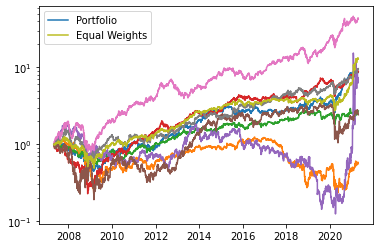

In [7]:

plt.plot((1+portfolio).cumprod(), label = 'Portfolio')
plt.plot((1+stocks).cumprod())
plt.plot((1+equal_weights).cumprod(), label = 'Equal Weights')
plt.yscale("log")
plt.legend()

In [8]:
empyrical.sharpe_ratio(stocks).max()

0.9922540366784204

In [9]:
empyrical.sharpe_ratio(equal_weights)

array([0.8148865])

In [10]:
empyrical.sharpe_ratio(portfolio)


array([0.70359781])

## Parameter Search
1. Median, Window_Size = 20, Tickers = ["GE", "PFE", "Starbucks], Sharpe:0.75383353 vs. 0.7161903905293208
2. Median, Window_Size = 20, Tickers = ["GE", "PFE","SBUX", "GME", "DAL", "AAPL", "GOOGL" ], Sharpe:  .68083264 vs .81624048

# Efficient Frontier (Historical Data)

In [11]:
mu = stocks.mean()
sigma = stocks.cov()


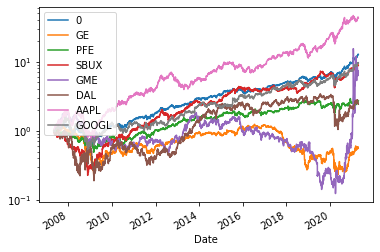

In [12]:
Ef = EfficientFrontier(mu, sigma)
weight_vector = Ef.efficient_return(mu.median())
weight_list = [weight_vector[ticker] for ticker in stocks.columns]
portfolio = stocks.dot(weight_list)
dataframe = pd.concat([portfolio, stocks], axis=1)
(1 + dataframe).cumprod().plot()
plt.yscale("log")

In [13]:
empyrical.sharpe_ratio(dataframe)

array([0.94757585, 0.06235019, 0.42571781, 0.650973  , 0.5370051 ,
       0.38784004, 0.99225404, 0.69764798])

In [14]:
empyrical.sharpe_ratio(portfolio)

0.9475758495693543

In [15]:
weight_vector

OrderedDict([('GE', 0.0),
             ('PFE', 0.3999495915608272),
             ('SBUX', 0.1281402418779298),
             ('GME', 0.0430524621657134),
             ('DAL', 0.0),
             ('AAPL', 0.2739330520308177),
             ('GOOGL', 0.1549246523647118)])

In [16]:
days = 20
sampled_means = stocks.resample(str(days)+"d").mean()
sampled_covars = [sample[1].cov() for sample in stocks.resample(str(days)+"d")]

E:\Python\envs\Mentorship\lib\site-packages\pandas\core\frame.py:8525: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
E:\Python\envs\Mentorship\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
E:\Python\envs\Mentorship\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [17]:
weight_dicts = [EfficientFrontier(mean,cov).min_volatility() for mean, cov in zip(sampled_means.values,sampled_covars)]

ValueError: P must be symmetric/Hermitian.

# Efficient Frontier Algorithm (rolling)

In [ ]:
days = 5
X = stocks.resample(str(days)+"d").mean()
dates = X.index[1:-1]
portfolio = pd.DataFrame()

saved_weights = []
r0s = []

for day in dates[:-1]: 
    sample = stocks[day:day+pd.offsets.DateOffset(days = (days-1))]
    #sample = stocks[day+pd.offsets.DateOffset(days = 7):day+pd.offsets.DateOffset(days=13)]

    mean = sample.mean(axis=0)
    covar = sample.cov()
    weights_vector = [EfficientFrontier(mean,covar).max_quadratic_utility()[ticker] for ticker in stocks.columns]
    portfolio = pd.concat([portfolio,stocks[day+pd.offsets.DateOffset(days = days):day+pd.offsets.DateOffset(days=((2*days)-1))].dot(weights_vector)])
    saved_weights.append(weights_vector)
portfolio = portfolio.sort_index()
saved_weights = pd.DataFrame(saved_weights, index = dates[:-1], columns = tickers)

## Efficient Frontier Testing and Analysis

In [ ]:
plt.stackplot(saved_weights['2020':'2020'].index, *(saved_weights[ticker]['2020':'2020'] for ticker in saved_weights.columns), labels=saved_weights.columns)
plt.legend()

In [ ]:
(1+pd.concat([portfolio,stocks],axis=1)).cumprod().plot()
plt.yscale('log')

In [ ]:
empyrical.sharpe_ratio(pd.concat([portfolio,stocks],axis=1))

In [ ]:
saved_weights.sum(axis=1).max()

In [ ]:
def Mean_Variance_Rolling(days):
    X = stocks.resample(str(days)+"d").mean()
    dates = X.index[1:-1]
    portfolio = pd.DataFrame()

    saved_weights = []
    r0s = []

    for day in dates[:-1]:
        #sample = stocks[day:day+pd.offsets.DateOffset(days = (days-1))]
        sample = stocks[day+pd.offsets.DateOffset(days = 7):day+pd.offsets.DateOffset(days=13)]

        mean = sample.mean(axis=0)
        covar = sample.cov()
        weights_vector = [EfficientFrontier(mean,covar).min_volatility()[ticker] for ticker in stocks.columns]
        portfolio = pd.concat([portfolio,stocks[day+pd.offsets.DateOffset(days = days):day+pd.offsets.DateOffset(days=((2*days)-1))].dot(weights_vector)])
        saved_weights.append(weights_vector)
    portfolio = portfolio.sort_index()
    saved_weights = pd.DataFrame(saved_weights, index = dates[:-1], columns = tickers)
    return portfolio
sample


In [ ]:
#start_time = time.time()
#with mp.Pool(mp.cpu_count()) as p:
#    all_portfolios = p.map(Mean_Variance_Rolling, range(10,15))
#print(time.time() - start_time)

In [ ]:
import test

In [ ]:
start_time = time.time()
y = test.run_test(tickers,stocks,range(5,255))
print(time.time() - start_time)

In [ ]:
max([empyrical.sharpe_ratio(i) for i in y])

# empyrical.sharpe_ratio(stocks).max()

In [ ]:
empyrical.sharpe_ratio(stocks.mean(axis=1))

In [ ]:
start_time = time.time()
y = [x+1 for x in range(10000)]
print(time.time() - start_time)

# Sharpe Ratio Correlation

In [ ]:
days = 21
X = stocks.resample(str(days)+"d").mean()
dates = X.index[1:-1]
portfolio = pd.DataFrame()

sharpe_ratios = []


for day in dates[:-1]: 
    sample = stocks["AAPL"][day:day+pd.offsets.DateOffset(days = (days-1))]
    sharpe_ratios.append(empyrical.calmar_ratio(sample))

sharpe_ratios_dataframe = pd.DataFrame(index = dates[:-1], columns = ["AAPL"], data = sharpe_ratios)


In [ ]:
X

In [ ]:
plt.scatter(dates[:-1], sharpe_ratios)


In [ ]:
X = np.array((dates[:-1] - dates[:-1].min())  / pd.Timedelta(1,'D')).reshape(-1,1)
Y = np.array(sharpe_ratios).flatten()

model = linear_model.LinearRegression(fit_intercept = True)
model.fit(X,Y)

y_pred = model.predict(X)

plt.plot(X.flatten(), y_pred.flatten())
plt.scatter(X,Y)
print(model.coef_,model.intercept_)